In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(cv2.__version__)
print(tf.__version__)

2023-12-05 10:57:00.146511: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 10:57:00.307399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 10:57:00.307463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 10:57:00.334221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 10:57:00.386218: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 10:57:00.387527: I tensorflow/core/platform/cpu_feature_guard.cc:1

4.8.1
2.15.0


In [2]:
def get_image_paths(root_folder, image_extensions=('.jpg', '.jpeg', '.png')):
    image_paths = []
    for foldername, __, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(image_extensions):
                image_paths.append(os.path.join(foldername, filename))
    return image_paths

# Specify the root folder
root_folder = 'data'

# Get image paths
image_paths = get_image_paths(root_folder)

In [3]:
def process_images(image_paths):
    for image_path in image_paths:
        # Read the image in color
        color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Ensure the image is not None
        if color_image is None:
            print(f"Error reading image: {image_path}")
            continue

        if color_image.shape[:2] != (64, 64):
            # Apply blur
            blurred_image = cv2.GaussianBlur(color_image, (5, 5), 0)

            # Resize to 64x64
            resized_image = cv2.resize(blurred_image, (64, 64))

            # Overwrite the image
            cv2.imwrite(image_path, resized_image)

0


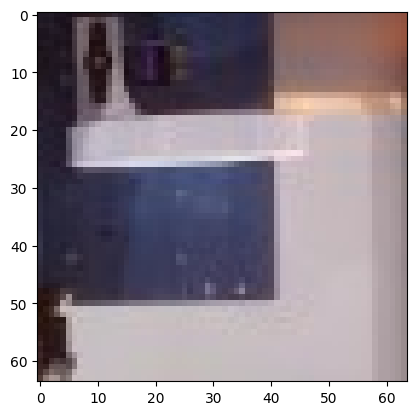

(704, 64, 64, 3)
[[[0.1254902  0.10196078 0.14509804]
  [0.1254902  0.10196078 0.14509804]
  [0.1372549  0.11372549 0.15686275]
  ...
  [0.57254902 0.34117647 0.28235294]
  [0.56470588 0.32941176 0.26666667]
  [0.55686275 0.31372549 0.25098039]]

 [[0.12156863 0.09803922 0.14117647]
  [0.11372549 0.09019608 0.13333333]
  [0.1254902  0.10196078 0.14509804]
  ...
  [0.57647059 0.34509804 0.28235294]
  [0.57647059 0.33333333 0.27058824]
  [0.56078431 0.31764706 0.24705882]]

 [[0.14509804 0.11372549 0.15294118]
  [0.1372549  0.10588235 0.14509804]
  [0.15294118 0.12156863 0.16470588]
  ...
  [0.58823529 0.35686275 0.28235294]
  [0.59215686 0.34117647 0.27058824]
  [0.57647059 0.32941176 0.25098039]]

 ...

 [[0.22745098 0.14509804 0.14117647]
  [0.21568627 0.1372549  0.13333333]
  [0.4        0.32156863 0.31764706]
  ...
  [0.6627451  0.60784314 0.62352941]
  [0.64313725 0.59215686 0.6       ]
  [0.60392157 0.55294118 0.56078431]]

 [[0.24705882 0.16470588 0.15686275]
  [0.35294118 0.2784

In [4]:
X = np.array(list(map(lambda path: cv2.imread(path, cv2.IMREAD_COLOR), image_paths)))
X = X / 255.0
Y = np.array([1 if 'cup' in path else 0 for path in image_paths])

display = 3
print(Y[display])
plt.imshow(X[display], cmap='gray')
plt.show()
print(X.shape)
print(X[display])

In [5]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with less verbosity
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1

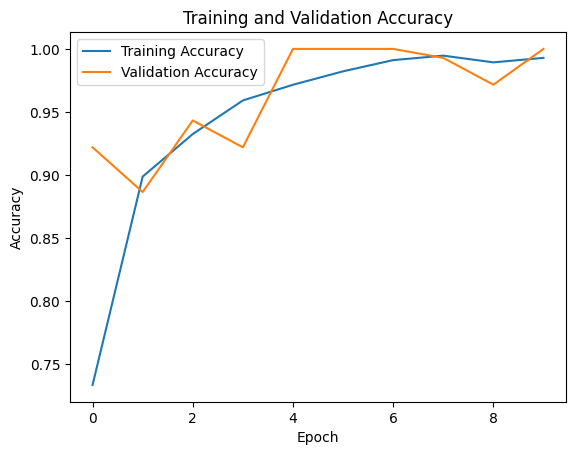

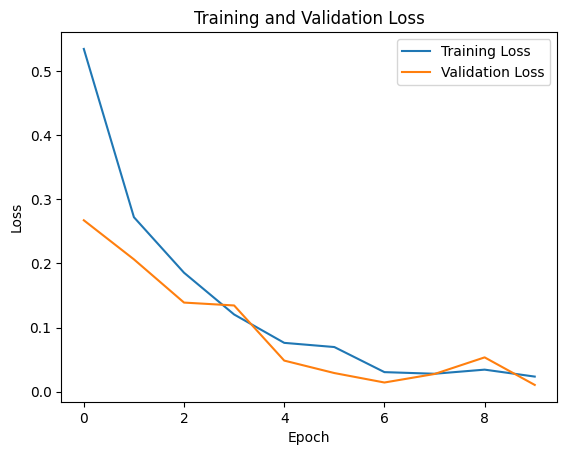

In [6]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Save the trained model
model.save('model.h5', save_format='h5')

/home/brian-vdb/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
